# MAAT-Core Reflection Demo
This notebook visualizes self-reflective safety-first optimization.

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from maat_core import Field, Constraint, MaatCore


In [17]:

def state_fn(x):
    x = float(x)
    dissonance = (
        np.sin(10 * x)**2
        + 10 * (x - 0.9)**2
        + 3 * np.exp(-15 * x)
    )
    return type("State", (), {
        "dissonance": dissonance,
        "complexity": np.exp(x),
        "val": x,
    })


In [18]:

H = Field("Harmony", lambda s: s.dissonance, 1.0)
R = Constraint("RespectBoundary", lambda s: 0.6 - s.val)
core = MaatCore([H], constraints=[R], safety_lambda=1e5)


In [19]:
def reflect(core, x0=0.9, steps=8):
    xs, lambdas = [], []
    x = x0
    last = None
    for i in range(steps):
        res = core.seek(state_fn, [x], use_annealing=(i==0), S=0.6, seed=42)
        x_new = float(res.x[0])
        xs.append(x_new)
        lambdas.append(core.safety_lambda)
        report = core.constraint_report(state_fn(x_new))
        violated = any(c["margin"] < -1e-6 for c in report)
        if violated:
            core.safety_lambda *= 2 
        else:
            core.safety_lambda /= 1.5
        if last is not None and abs(x_new-last) < 1e-6:
            break
        last = x_new
        x = x_new
    return xs, lambdas


In [20]:
history_x = []
history_loss = []

x0 = [0.9]
last_x = None

for step in range(10):
    use_annealing = (step == 0)

    res = core.seek(
        state_fn,
        x0=x0,
        S=0.6,
        use_annealing=use_annealing,
        seed=42
    )

    x_new = float(res.x[0])
    loss_new = float(res.fun)

    history_x.append(x_new)
    history_loss.append(loss_new)

    report = core.constraint_report(state_fn(x_new))
    violated = any(r["margin"] < -1e-4 for r in report)

    print(f"\nStep {step}:")
    print("  x =", round(x_new, 4))
    print("  objective =", round(loss_new, 6))
    for r in report:
        print("  -", r["constraint"], r["status"], "(margin=", round(r["margin"], 6), ")")

    if violated:
        core.safety_lambda *= 2
        print("  REFLECTION: unsafe → increasing safety_lambda to", int(core.safety_lambda))
    else:
        if core.safety_lambda > 1e5:
            core.safety_lambda /= 1.5
            print("  REFLECTION: stable & safe → relaxing safety_lambda to", int(core.safety_lambda))

    if last_x is not None and abs(x_new - last_x) < 1e-6:
        print("  REFLECTION: converged → stopping loop")
        break

    last_x = x_new
    x0 = [x_new]


Step 0:
  x = 0.6001
  objective = 0.97812
  - RespectBoundary VIOLATION (margin= -5.7e-05 )

Step 1:
  x = 0.6001
  objective = 0.97812
  - RespectBoundary VIOLATION (margin= -5.7e-05 )
  REFLECTION: converged → stopping loop


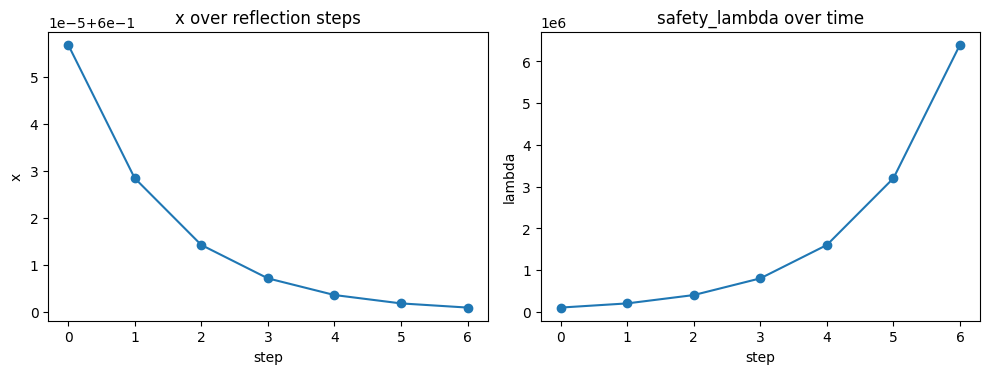

In [21]:
xs, lambdas = reflect(core)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(xs, marker="o")
plt.title("x over reflection steps")
plt.xlabel("step"); plt.ylabel("x")

plt.subplot(1,2,2)
plt.plot(lambdas, marker="o")
plt.title("safety_lambda over time")
plt.xlabel("step"); plt.ylabel("lambda")
plt.tight_layout()
plt.show()

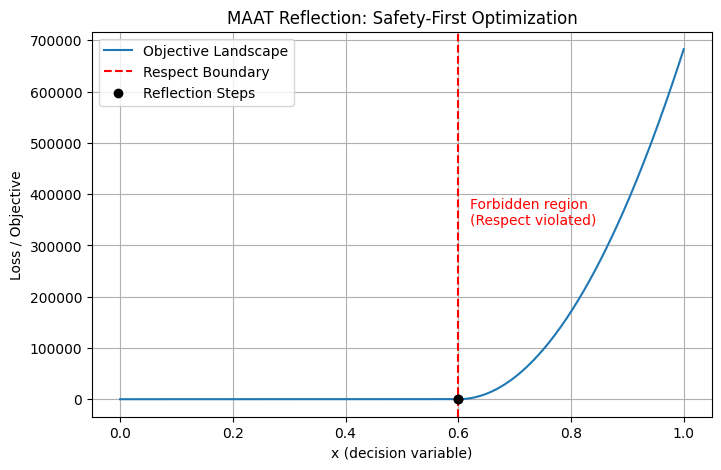

In [22]:
# Landscape sampling
xs = np.linspace(0, 1, 400)
losses = []

for x in xs:
    state = state_fn(x)
    losses.append(core.integrate(state))

losses = np.array(losses)

plt.figure(figsize=(8,5))
plt.plot(xs, losses, label="Objective Landscape")
plt.axvline(0.6, color="red", linestyle="--", label="Respect Boundary")
plt.scatter(history_x, history_loss, color="black", zorder=5, label="Reflection Steps")
plt.text(0.62, max(losses)*0.5,
         "Forbidden region\n(Respect violated)",
         color="red")
plt.xlabel("x (decision variable)")
plt.ylabel("Loss / Objective")
plt.title("MAAT Reflection: Safety-First Optimization")
plt.legend()
plt.grid(True)
plt.show()